In [10]:
using Oceananigans
using Oceananigans.Units
using GLMakie
using JLD2
using NCDatasets

In [11]:
using Oceananigans: architecture

In [12]:
using DelimitedFiles, FileIO

In [13]:
using ClimaOcean

In [14]:
using Oceananigans.Operators: ℑxyᶠᶜᵃ, ℑxyᶜᶠᵃ
using Oceananigans.Operators: Δzᵃᵃᶜ

In [15]:
using Statistics
using JLD2
using Printf
using SeawaterPolynomials.TEOS10: TEOS10EquationOfState
using CUDA: @allowscalar

In [16]:
using SeawaterPolynomials.TEOS10

In [17]:
arch = CPU()

CPU()

In [74]:
save_interval = 1hours

3600.0

# Grid

In [19]:
# z_levels = stretched_vertical_faces(depth = 300, 
#                              surface_layer_Δz = 2.5, 
#                              stretching = PowerLawStretching(1.090), 
#                              surface_layer_height = 30)
z_levels = -reverse([0.5, 1, 2, 3, 4, 6, 8, 9, 10, 12, 16, 20, 30, 50, 100, 150, 200, 250, 275])

19-element Vector{Float64}:
 -275.0
 -250.0
 -200.0
 -150.0
 -100.0
  -50.0
  -30.0
  -20.0
  -16.0
  -12.0
  -10.0
   -9.0
   -8.0
   -6.0
   -4.0
   -3.0
   -2.0
   -1.0
   -0.5

In [20]:
writedlm( "z-grid_Tyr.csv",  z_levels, ',')

In [21]:
Nx = 43
Ny = 54
Nz = length(z_levels)-1

18

In [22]:
underlying_grid = RectilinearGrid(topology=(Bounded, Bounded, Bounded), size=(Nx, Ny, Nz),
                                        x = (0, 500*Nx), y = (0, 500*Ny),
                                        z = z_levels, halo=(7,7,7))

43×54×18 RectilinearGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo
├── Bounded  x ∈ [0.0, 21500.0] regularly spaced with Δx=500.0
├── Bounded  y ∈ [0.0, 27000.0] regularly spaced with Δy=500.0
└── Bounded  z ∈ [-275.0, -0.5] variably spaced with min(Δz)=0.5, max(Δz)=50.0

In [23]:
@load "bathymetry_Tyrifjord.jld2" depth

1-element Vector{Symbol}:
 :depth

In [24]:
depth

43×54 Matrix{Float64}:
 0.0    0.0       0.0       0.0     …   0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0     …   0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0     …   0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 ⋮                                  ⋱   ⋮                       
 0.0    0.0       0.0       

In [25]:
grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(depth); active_cells_map = true)

43×54×18 ImmersedBoundaryGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo:
├── immersed_boundary: GridFittedBottom(mean(z)=-20.6841, min(z)=-202.905, max(z)=0.0)
├── underlying_grid: 43×54×18 RectilinearGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo
├── Bounded  x ∈ [0.0, 21500.0] regularly spaced with Δx=500.0
├── Bounded  y ∈ [0.0, 27000.0] regularly spaced with Δy=500.0
└── Bounded  z ∈ [-275.0, -0.5] variably spaced with min(Δz)=0.5, max(Δz)=50.0

# Physics

In [26]:
const surface_νz = 1e-2
const background_νz = 1e-4
const background_κz = 1e-5

@inline νz(x, y, z, t) = ifelse(z > -30, surface_νz, background_νz)

horizontal_viscosity = HorizontalScalarDiffusivity(ν=1e3)
vertical_viscosity   = VerticalScalarDiffusivity(VerticallyImplicitTimeDiscretization(),
                                                 ν=νz, κ=background_κz)
convective_adjustment = ConvectiveAdjustmentVerticalDiffusivity(convective_κz=0.1)
κ_skew = 900.0      # [m² s⁻¹] skew diffusivity
κ_symmetric = 900.0 # [m² s⁻¹] symmetric diffusivity

gent_mcwilliams_diffusivity = IsopycnalSkewSymmetricDiffusivity(; κ_skew, κ_symmetric,
                                                                slope_limiter = FluxTapering(1e-2))

    
closure = (
    vertical_viscosity,
    horizontal_viscosity,
    convective_adjustment,
    gent_mcwilliams_diffusivity,
)

(VerticalScalarDiffusivity{VerticallyImplicitTimeDiscretization}(ν=νz (generic function with 1 method), κ=1.0e-5), HorizontalScalarDiffusivity{ExplicitTimeDiscretization}(ν=1000.0, κ=0.0), ConvectiveAdjustmentVerticalDiffusivity{VerticallyImplicitTimeDiscretization}(background_κz=0.0 convective_κz=0.1 background_νz=0.0 convective_νz=0.0), IsopycnalSkewSymmetricDiffusivity: (κ_symmetric=900.0, κ_skew=900.0, (isopycnal_tensor=Oceananigans.TurbulenceClosures.SmallSlopeIsopycnalTensor{Float64}(0.0), slope_limiter=FluxTapering{Float64}(0.01)))

# Boundary conditions (u, v, T, S)

In [27]:
reference_density        = 1000.0
reference_heat_capacity  = 3991.0
reference_salinity       = 0

0

In [93]:
# Files contain 12 arrays of monthly-averaged data from 1992
# @info "Reading boundary conditions..."; start=time_ns()
# boundary_conditions_file = jldopen("surface_boundary_conditions_360_150_75S_75N.jld2")
# τˣ = - boundary_conditions_file["τˣ"] ./ reference_density
# τʸ = - boundary_conditions_file["τʸ"] ./ reference_density

[ Info: Reading boundary conditions...
┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 C:\Users\ABE\.julia\packages\JLD2\VWinU\src\JLD2.jl:300


LoadError: SystemError: opening file "surface_boundary_conditions_360_150_75S_75N.jld2": No such file or directory

In [ ]:
# Convert boundary conditions arrays to GPU (CPU here)
# τˣ = on_architecture(arch, τˣ)
# τʸ = on_architecture(arch, τʸ)

### Wind stress
https://en.wikipedia.org/wiki/Wind_stress

In [45]:
0.0015*100

0.15

In [50]:
Cd = 0.0015
uwind = 10
vwind = 8
ρₐᵢᵣ = 1

1

In [51]:
τˣ = ρₐᵢᵣ*Cd*(uwind^2)/reference_density  #[0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075]
τʸ = -ρₐᵢᵣ*Cd*(vwind^2)/reference_density  #[0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115]

-9.6e-5

In [52]:
##### Boundary conditions / time-dependent fluxes 

const Nyears = 2.0
const Nmonths = 12
const thirty_days = 30days

@inline current_time_index(time, tot_months) = mod(unsafe_trunc(Int32, time / thirty_days), tot_months) + 1
@inline next_time_index(time, tot_months) = mod(unsafe_trunc(Int32, time / thirty_days) + 1, tot_months) + 1
@inline cyclic_interpolate(u₁::Number, u₂, time) = u₁ + mod(time / thirty_days, 1) * (u₂ - u₁)

Δz_top = @allowscalar Δzᵃᵃᶜ(1, 1, grid.Nz, grid.underlying_grid)
Δz_bottom = @allowscalar Δzᵃᵃᶜ(1, 1, 1, grid.underlying_grid)

@inline function surface_wind_stress(i, j, grid, clock, fields, τ)
    time = clock.time
    n₁ = current_time_index(time, Nmonths)
    n₂ = next_time_index(time, Nmonths)

    @inbounds begin  # inbounds for faster performance, doesn't check the boundaries of the array
        τ₁ = τ[i, j, n₁]
        τ₂ = τ[i, j, n₂]
    end

    return cyclic_interpolate(τ₁, τ₂, time)
end

Δz_top = @allowscalar grid.Δzᵃᵃᶜ[Nz]

# Linear bottom drag:
μ = 0.003 # Non dimensional

@inline speedᶠᶜᶜ(i, j, k, grid, fields) = @inbounds sqrt(fields.u[i, j, k]^2 + ℑxyᶠᶜᵃ(i, j, k, grid, fields.v)^2)
@inline speedᶜᶠᶜ(i, j, k, grid, fields) = @inbounds sqrt(fields.v[i, j, k]^2 + ℑxyᶜᶠᵃ(i, j, k, grid, fields.u)^2)

@inline u_bottom_drag(i, j, grid, clock, fields, μ) = @inbounds - μ * fields.u[i, j, 1] * speedᶠᶜᶜ(i, j, 1, grid, fields)
@inline v_bottom_drag(i, j, grid, clock, fields, μ) = @inbounds - μ * fields.v[i, j, 1] * speedᶜᶠᶜ(i, j, 1, grid, fields)

@inline u_immersed_bottom_drag(i, j, k, grid, clock, fields, μ) = @inbounds - μ * fields.u[i, j, k] * speedᶠᶜᶜ(i, j, k, grid, fields)
@inline v_immersed_bottom_drag(i, j, k, grid, clock, fields, μ) = @inbounds - μ * fields.v[i, j, k] * speedᶜᶠᶜ(i, j, k, grid, fields)

drag_u = FluxBoundaryCondition(u_immersed_bottom_drag, discrete_form=true, parameters = μ)
drag_v = FluxBoundaryCondition(v_immersed_bottom_drag, discrete_form=true, parameters = μ)

no_slip_bc = ValueBoundaryCondition(0)

u_immersed_bc = ImmersedBoundaryCondition(bottom = drag_u,
                                          west = no_slip_bc,
                                          east = no_slip_bc,
                                          south = no_slip_bc,
                                          north = no_slip_bc)

v_immersed_bc = ImmersedBoundaryCondition(bottom = drag_v,
                                          west = no_slip_bc,
                                          east = no_slip_bc,
                                          south = no_slip_bc,
                                          north = no_slip_bc)

u_bottom_drag_bc = FluxBoundaryCondition(u_bottom_drag, discrete_form = true, parameters = μ)
v_bottom_drag_bc = FluxBoundaryCondition(v_bottom_drag, discrete_form = true, parameters = μ)

u_wind_stress_bc = FluxBoundaryCondition(surface_wind_stress, discrete_form = true, parameters = τˣ);
v_wind_stress_bc = FluxBoundaryCondition(surface_wind_stress, discrete_form = true, parameters = τʸ);

┌ Warning: `ImmersedBoundaryCondition` is experimental.
└ @ Oceananigans.ImmersedBoundaries C:\Users\ABE\.julia\packages\Oceananigans\E4XVr\src\ImmersedBoundaries\immersed_boundary_condition.jl:59
┌ Warning: `ImmersedBoundaryCondition` is experimental.
└ @ Oceananigans.ImmersedBoundaries C:\Users\ABE\.julia\packages\Oceananigans\E4XVr\src\ImmersedBoundaries\immersed_boundary_condition.jl:59


In [53]:
u_bcs = FieldBoundaryConditions(top = u_wind_stress_bc,
                                bottom = u_bottom_drag_bc,
                                immersed = u_immersed_bc)

v_bcs = FieldBoundaryConditions(top = v_wind_stress_bc,
                                bottom = v_bottom_drag_bc,
                                immersed = v_immersed_bc)

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── east: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── south: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── north: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── bottom: FluxBoundaryCondition: DiscreteBoundaryFunction v_bottom_drag with parameters 0.003
├── top: FluxBoundaryCondition: DiscreteBoundaryFunction surface_wind_stress with parameters -9.6e-5
└── immersed: ImmersedBoundaryCondition with west=Value, east=Value, south=Value, north=Value, bottom=Flux, top=Nothing

In [54]:
boundary_conditions = (u=u_bcs, v=v_bcs)

(u = Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── east: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── south: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── north: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── bottom: FluxBoundaryCondition: DiscreteBoundaryFunction u_bottom_drag with parameters 0.003
├── top: FluxBoundaryCondition: DiscreteBoundaryFunction surface_wind_stress with parameters 0.00015
└── immersed: ImmersedBoundaryCondition with west=Value, east=Value, south=Value, north=Value, bottom=Flux, top=Nothing, v = Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── east: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── south: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── north: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)

File Nx*Ny with athmospheric forcing

# Model

In [104]:
model = HydrostaticFreeSurfaceModel(; grid,
                                    closure,
                                    buoyancy=BuoyancyTracer(),
                                    boundary_conditions,
                                    momentum_advection = VectorInvariant(), 
                                    tracer_advection = WENO(underlying_grid),
                                    tracers = (:T, :b))

┌ Warning: `ImmersedBoundaryCondition` is experimental.
└ @ Oceananigans.ImmersedBoundaries C:\Users\ABE\.julia\packages\Oceananigans\E4XVr\src\ImmersedBoundaries\immersed_boundary_condition.jl:59
┌ Warning: `ImmersedBoundaryCondition` is experimental.
└ @ Oceananigans.ImmersedBoundaries C:\Users\ABE\.julia\packages\Oceananigans\E4XVr\src\ImmersedBoundaries\immersed_boundary_condition.jl:59


HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── grid: 43×54×18 ImmersedBoundaryGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo
├── timestepper: QuasiAdamsBashforth2TimeStepper
├── tracers: (T, b)
├── closure: Tuple with 4 closures:
│   ├── VerticalScalarDiffusivity{VerticallyImplicitTimeDiscretization}(ν=νz (generic function with 1 method), κ=(T=1.0e-5, b=1.0e-5))
│   ├── HorizontalScalarDiffusivity{ExplicitTimeDiscretization}(ν=1000.0, κ=(T=0.0, b=0.0))
│   ├── ConvectiveAdjustmentVerticalDiffusivity{VerticallyImplicitTimeDiscretization}(background_κz=0.0 convective_κz=0.1 background_νz=0.0 convective_νz=0.0)
│   └── IsopycnalSkewSymmetricDiffusivity(κ_skew=900.0, κ_symmetric=900.0)
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
├── free surface: ImplicitFreeSurface with gravitational acceleration 9.80665 m s⁻²
│   └── solver: MatrixImplicitFreeSurfaceSolver
└── coriolis: Nothing

## Initial conditions

In [105]:
tprof = reverse([12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 10, 7, 5.1, 4.5, 4.25, 4.0, 3.9, 3.9])
T₀ = Array{Float64}(undef, 43, 54, 18)
for i = 1:Nx
    for j = 1:Ny
        T₀[i, j, :] = tprof
    end
end

In [106]:
set!(model, T=T₀)

# Simulation

In [107]:
Δt = 20seconds
stop_time = 10days

864000.0

In [108]:
simulation = Simulation(model; Δt, stop_time)

Simulation of HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 20 seconds
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 10 days
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [109]:
progress(sim) = @info "Time : $(prettytime(sim.model.clock.time)),
                        max(|u|): $(maximum(abs, sim.model.velocities.u)),
                        max(T): $(maximum(model.tracers.T))"

progress (generic function with 1 method)

In [110]:
simulation.callbacks[:progress] = Callback(progress, IterationInterval(50))

Callback of progress on IterationInterval(50)

In [111]:
u, v, w = model.velocities
T = model.tracers.T

43×54×18 Field{Center, Center, Center} on ImmersedBoundaryGrid on CPU
├── grid: 43×54×18 ImmersedBoundaryGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: ZeroFlux, east: ZeroFlux, south: ZeroFlux, north: ZeroFlux, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
└── data: 57×68×32 OffsetArray(::Array{Float64, 3}, -6:50, -6:61, -6:25) with eltype Float64 with indices -6:50×-6:61×-6:25
    └── max=12.5, min=4.0, mean=10.8821

In [112]:
simulation.output_writers[:surface_fields] =
    JLD2OutputWriter(model, (; u, v, w, T),
                     schedule = TimeInterval(save_interval),
                     filename = "test3_snapshots",
                     with_halos = true,
                     overwrite_existing = true)

JLD2OutputWriter scheduled on TimeInterval(1 hour):
├── filepath: .\test3_snapshots.jld2
├── 4 outputs: (u, v, w, T)
├── array type: Array{Float64}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

In [113]:
run!(simulation)

[ Info: Initializing simulation...
┌ Info: Time : 0 seconds,
│                         max(|u|): 0.0,
└                         max(T): 12.5
[ Info:     ... simulation initialization complete (118.557 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (61.723 ms).
┌ Info: Time : 16.667 minutes,
│                         max(|u|): 0.0476426416647183,
└                         max(T): 12.500000033302305
┌ Info: Time : 33.333 minutes,
│                         max(|u|): 0.06179304767767052,
└                         max(T): 12.500000072860802
┌ Info: Time : 50 minutes,
│                         max(|u|): 0.06818516846741861,
└                         max(T): 12.50000020708823
┌ Info: Time : 1.111 hours,
│                         max(|u|): 0.07128132987679502,
└                         max(T): 12.500000147255074
┌ Info: Time : 1.389 hours,
│                         max(|u|): 0.07283535037369278,
└                         max(T): 12.500000292742282
┌ Info:

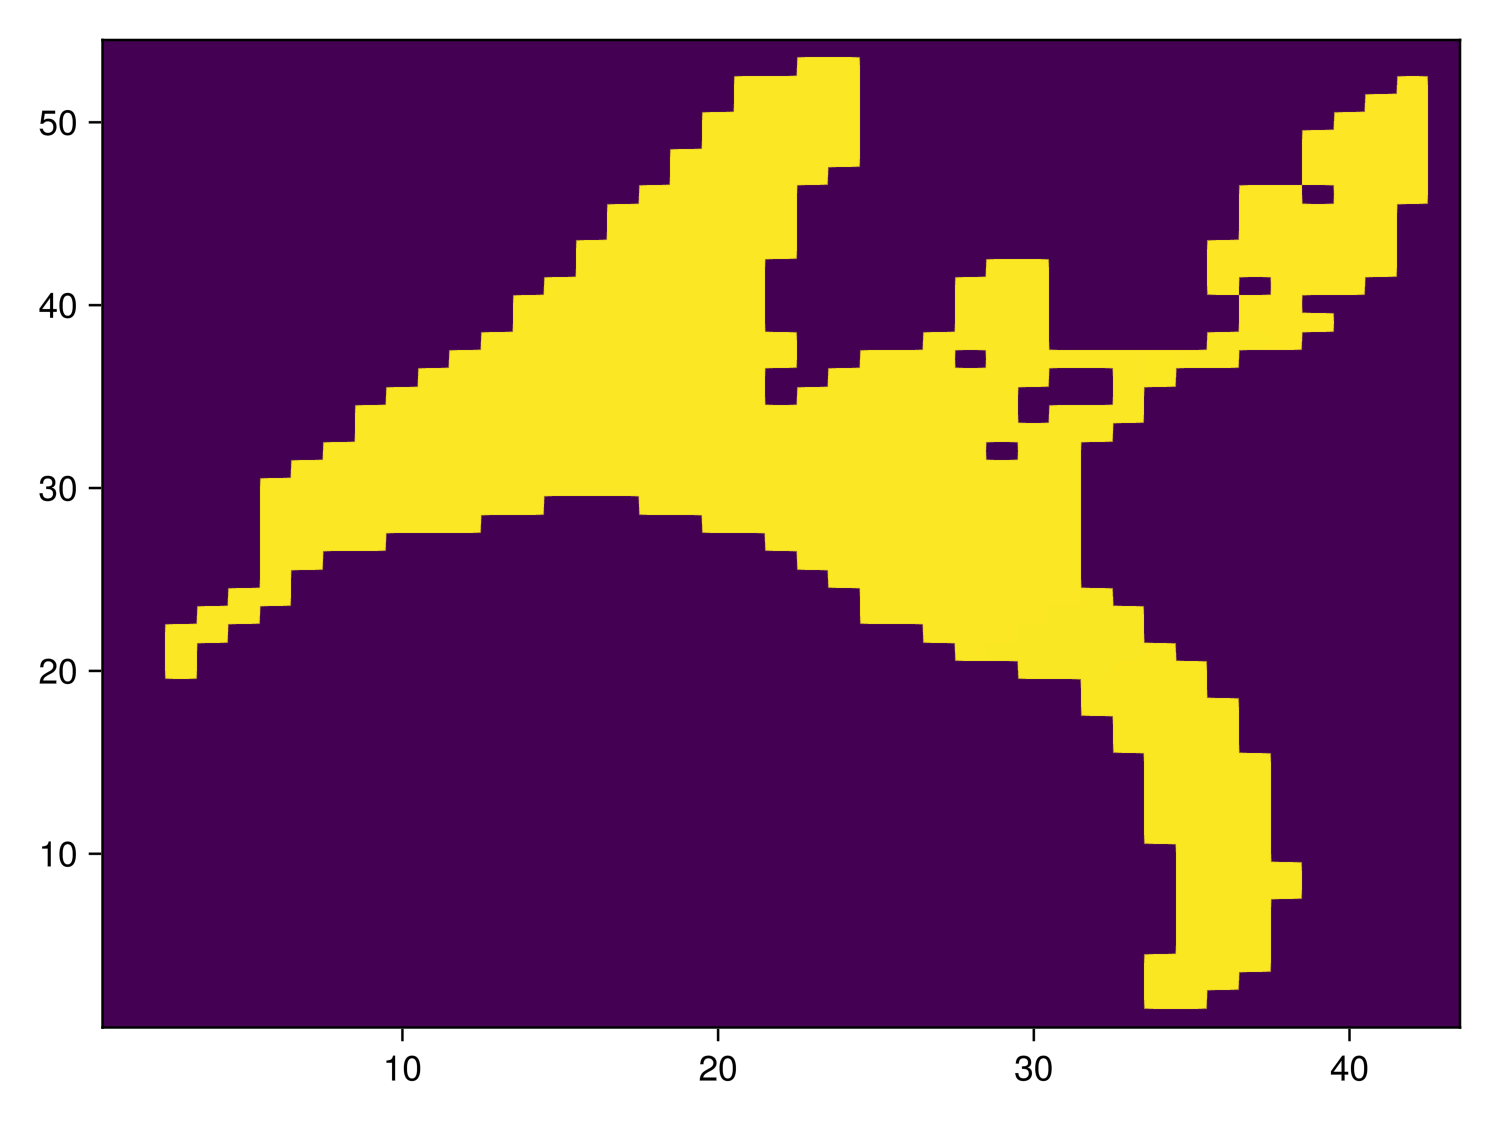

In [114]:
heatmap(interior(model.tracers.T, :, :, grid.Nz))

In [115]:
# Record a video
#
# (1) Zonal velocity (u)
# (2) Meridional velocity (v)
# (3) Temperature (T)
# (4) Salinity (S)
u_series = FieldTimeSeries("test3_snapshots.jld2", "u")
v_series = FieldTimeSeries("test3_snapshots.jld2", "v")
T_series = FieldTimeSeries("test3_snapshots.jld2", "T")

43×54×18×241 FieldTimeSeries{InMemory} located at (Center, Center, Center) of T at test3_snapshots.jld2
├── grid: 43×54×18 ImmersedBoundaryGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo
├── indices: (:, :, :)
├── time_indexing: Linear()
├── backend: InMemory()
├── path: test3_snapshots.jld2
├── name: T
└── data: 57×68×32×241 OffsetArray(::Array{Float64, 4}, -6:50, -6:61, -6:25, 1:241) with eltype Float64 with indices -6:50×-6:61×-6:25×1:241
    └── max=12.5, min=0.0, mean=0.609148

In [116]:
iter = Observable(1)

u = @lift begin
    f = interior(u_series[$iter], :, :, 18)
    f[f .== 0] .= NaN
    f
end
T = @lift begin
    f = interior(T_series[$iter], :, :, 18)
    f[f .== 0] .= NaN
    f
end
usec = @lift begin
    f = interior(u_series[$iter], :, 30, :)
    f[f .== 0] .= NaN
    f
end
Tsec = @lift begin
    f = interior(T_series[$iter], :, 30, :)
    f[f .== 0] .= NaN
    f
end

fig = Figure()

ax  = Axis(fig[1, 1], title = "surface zonal velocity ms⁻¹")
hm = heatmap!(u, colormap = :lipari, colorrange=(-0.08, 0))
Colorbar(fig[1, 1][1, 2], hm, ticks = 0.0:-0.01:-0.08)

ax  = Axis(fig[1, 2], title = "zonal velocity ms⁻¹")
hm = heatmap!(usec, colormap = :lipari, colorrange=(-0.08, 0))
Colorbar(fig[1, 2][1, 2], hm, ticks = 0.0:-0.01:-0.08)

ax  = Axis(fig[2, 1], title = "surface temperature ᵒC")
hm = heatmap!(T, colormap =  Reverse(:Spectral), colorrange=(12.495,12.505))
Colorbar(fig[2, 1][1, 2], hm, ticks = 12.495:0.001:12.505)

ax  = Axis(fig[2, 2], title = "temperature ᵒC")
hm = heatmap!(Tsec, colormap = Reverse(:Spectral), colorrange=(4,13))
Colorbar(fig[2, 2][1, 2], hm, ticks = 4:1:13)

GLMakie.record(fig, "Tyr-sec2_video.mp4", 1:length(u_series.times); framerate = 5) do i
    @info "recording iteration $i"
    iter[] = i    
end

[ Info: recording iteration 1
[ Info: recording iteration 2
[ Info: recording iteration 3
[ Info: recording iteration 4
[ Info: recording iteration 5
[ Info: recording iteration 6
[ Info: recording iteration 7
[ Info: recording iteration 8
[ Info: recording iteration 9
[ Info: recording iteration 10
[ Info: recording iteration 11
[ Info: recording iteration 12
[ Info: recording iteration 13
[ Info: recording iteration 14
[ Info: recording iteration 15
[ Info: recording iteration 16
[ Info: recording iteration 17
[ Info: recording iteration 18
[ Info: recording iteration 19
[ Info: recording iteration 20
[ Info: recording iteration 21
[ Info: recording iteration 22
[ Info: recording iteration 23
[ Info: recording iteration 24
[ Info: recording iteration 25
[ Info: recording iteration 26
[ Info: recording iteration 27
[ Info: recording iteration 28
[ Info: recording iteration 29
[ Info: recording iteration 30
[ Info: recording iteration 31
[ Info: recording iteration 32
[ Info: recording

"Tyr-sec2_video.mp4"